In [1]:
import pandas as pd
import numpy as np
import json
from matplotlib import pyplot as plt
from matplotlib.cm import tab10,tab20,tab20b,tab20c

In [2]:
import matplotlib
font = {'size'   : 14}
matplotlib.rc('font', **font)

In [3]:
def plot_df(df,ax=None):
    if ax is None:
        fig,ax = plt.subplots(figsize=(9,7))
    for dose in ["dose1","dose2","booster1","booster2"]:
        ax.plot(df.index.get_level_values("measure_date"),df[dose],label=dose)
    ax.legend()

## CDPHE Data
Downloaded from the `doses_by_county_by_agegroup` view on BigQuery.

In [4]:
with open("/Users/andrewhill/PycharmProjects/covid-rmw-model/covid_model/input/rmw_region_definitions.json","r") as f:
    region_defs = json.load(f)
fips_to_region = {r:k for k,v in region_defs.items() for r in v["counties_fips"]}

In [5]:
# Read CDPHE data
cdphe_data = pd.read_csv("bq-results-20221129-041017-1669695066461.csv",parse_dates=["measure_date"],keep_default_na=False,index_col=["measure_date","age_group"])
# Map the FIPS counties to regions
cdphe_data["region_id"] = cdphe_data["county_id"].replace(fips_to_region)
# Calculate dose1 as the sum of the mRNA and JnJ doses.
cdphe_data["dose1"] = cdphe_data["dose1_mrna"] + cdphe_data["dose1_jnj"]
# Drop unused columns
cdphe_data.drop(columns=["county_id","dose1_mrna","dose1_jnj"],inplace=True)
# Rename dose2 for compatibility
cdphe_data.rename(columns={"dose2_mrna":"dose2"},inplace=True)
# Add region IDs to the index
cdphe_data.set_index("region_id",append=True,inplace=True)
# Rearrange index levels
cdphe_data = cdphe_data.reorder_levels(["measure_date","region_id","age_group"])

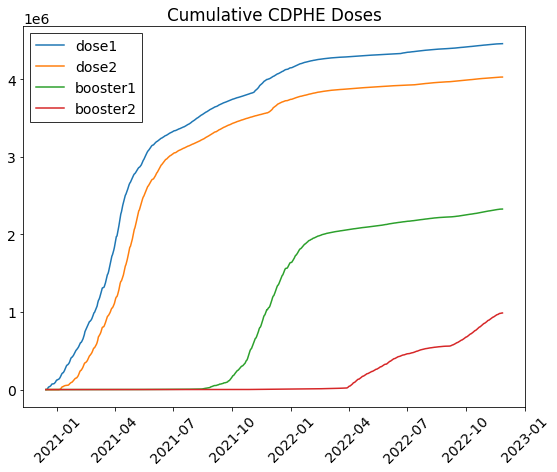

In [16]:
sum_cdphe_data = cdphe_data.groupby("measure_date").sum()
sum_cdphe_data_cumulative = sum_cdphe_data.cumsum()
fig,ax = plt.subplots(figsize=(9,7))
for dose in ["dose1","dose2","booster1","booster2"]:   
    ax.plot(sum_cdphe_data_cumulative.index,sum_cdphe_data_cumulative[dose],label=dose)
ax.legend(fancybox=False,edgecolor="black")
ax.tick_params(axis='x', labelrotation = 45)
#plot_df(sum_cdphe_data_cumulative)
plt.title("Cumulative CDPHE Doses")
plt.savefig("cumulative_cdphe_doses.png")

# CDC Vaccination Data
Provided by Irina for the RMW model.

In [17]:
cdc_data = pd.read_csv("/Users/andrewhill/RstudioProjects/vax_data/CO_VaxbyRegion_20221121.csv",parse_dates=["measure_date"],index_col=["measure_date","region_id","state","age_grp"])
cdc_data.rename(columns={"primaryseries":"dose2"},inplace=True)
cdc_data = cdc_data.fillna(0)

Compare the raw counts of vaccinations between the CDC and CDPHE data

In [18]:
cdc_data.groupby("age_grp")[["dose1","dose2","booster1","booster2"]].sum().astype(int)

,dose1,dose2,booster1,booster2
age_grp,,,,
0-17 years,593861,497959,161629,0
18-64 years,3271451,2881131,1554838,274239
65 plus,892439,811733,650491,422078


In [19]:
cdphe_data.groupby("age_group")[["dose1","dose2","booster1","booster2"]].sum()

,dose1,dose2,booster1,booster2
age_group,,,,
0-19,693983,607626,241125,41058
20-39,1412180,1238965,578293,142241
40-64,1528658,1414302,903994,400156
65+,826106,769500,604752,404586


## Step 1: Construct New Age Groups

Read in population by age estimates. These won't match our numbers exactly, but we can use them to shift the age groups according to what our model expects.

I downloaded this data from: https://demography.dola.colorado.gov/assets/html/state.html

In [20]:
pop_by_age = pd.read_csv("sya-region.csv",skiprows=1,index_col=["region","year","age","datatype"])
state_pop_by_age = pop_by_age.loc[("Colorado",2020,slice(None),"Estimate")].totalpopulation

In [21]:
state_pop_by_age

age
0      63350
1      62754
2      64239
3      65780
4      67505
       ...  
96      2357
97      1749
98      1319
99       956
100     1309
Name: totalpopulation, Length: 101, dtype: int64

The sum of populations for the state of Colorado is 5,807,719.

This is pretty close.

In [22]:
state_pop_by_age.sum()

5784140

`state_pop_proportions` calculates what percentage of the state population has each age.

The model's current age categories are:
- 0-19
- 20-39
- 40-64
- 65+

This data has categories:
- 0-17
- 18-64
- 65+

We can make a matrix that redistributes the values from the current three categories into the four required categories for the model:

In [23]:
max_age = state_pop_by_age.index.max()
rows = [set(range(0,17+1)),set(range(18,64+1)),set(range(65,max_age))]
cols = [set(range(0,19+1)),set(range(20,39+1)),set(range(40,64+1)),set(range(65,max_age))]
redist_mat = np.zeros((3,4))
for i,row in enumerate(rows):
    for j,col in enumerate(cols):
        intersect_idx = list(row.intersection(col))
        redist_mat[i,j] = state_pop_by_age[intersect_idx].sum() / state_pop_by_age[list(row)].sum()

In [24]:
redist_df = pd.DataFrame(redist_mat,index=["0-17 years","18-64 years","65 plus"],columns=["0-19","20-39","40-64","65+"])
redist_df.columns.name = "age_group"
redist_df

age_group,0-19,20-39,40-64,65+
0-17 years,1.000000,0.000000,0.000000,0.0
18-64 years,0.043605,0.459266,0.497128,0.0
65 plus,0.000000,0.000000,0.000000,1.0


Calculate total number of doses (to sanity check that our redistribution does not affect total numbers)

In [25]:
cdc_data.sum()

dose1       4757752.0
dose2       4190823.0
booster1    2366958.0
booster2     696317.0
dtype: float64

Create redistributed CDC data

In [26]:
cdc_data.columns.name = "dose"
cdc_data_redist = cdc_data.unstack(level="age_grp").stack(level="dose").dot(redist_df).unstack().stack(level="age_group")

Our total values are still as expected!

In [27]:
cdc_data_redist.sum()

dose
booster1    2366958.0
booster2     696317.0
dose1       4757752.0
dose2       4190823.0
dtype: float64

In [28]:
cdc_data_redist.groupby("age_group")[["dose1","dose2","booster1","booster2"]].sum().astype(int)

dose,dose1,dose2,booster1,booster2
age_group,,,,
0-19,736513,623591,229427,11958
20-39,1502468,1323206,714084,125948
40-64,1626331,1432292,772954,136331
65+,892439,811733,650491,422078


In [29]:
cdphe_data.groupby("age_group")[["dose1","dose2","booster1","booster2"]].sum()

,dose1,dose2,booster1,booster2
age_group,,,,
0-19,693983,607626,241125,41058
20-39,1412180,1238965,578293,142241
40-64,1528658,1414302,903994,400156
65+,826106,769500,604752,404586


Plot cumulative vaccinations over time.

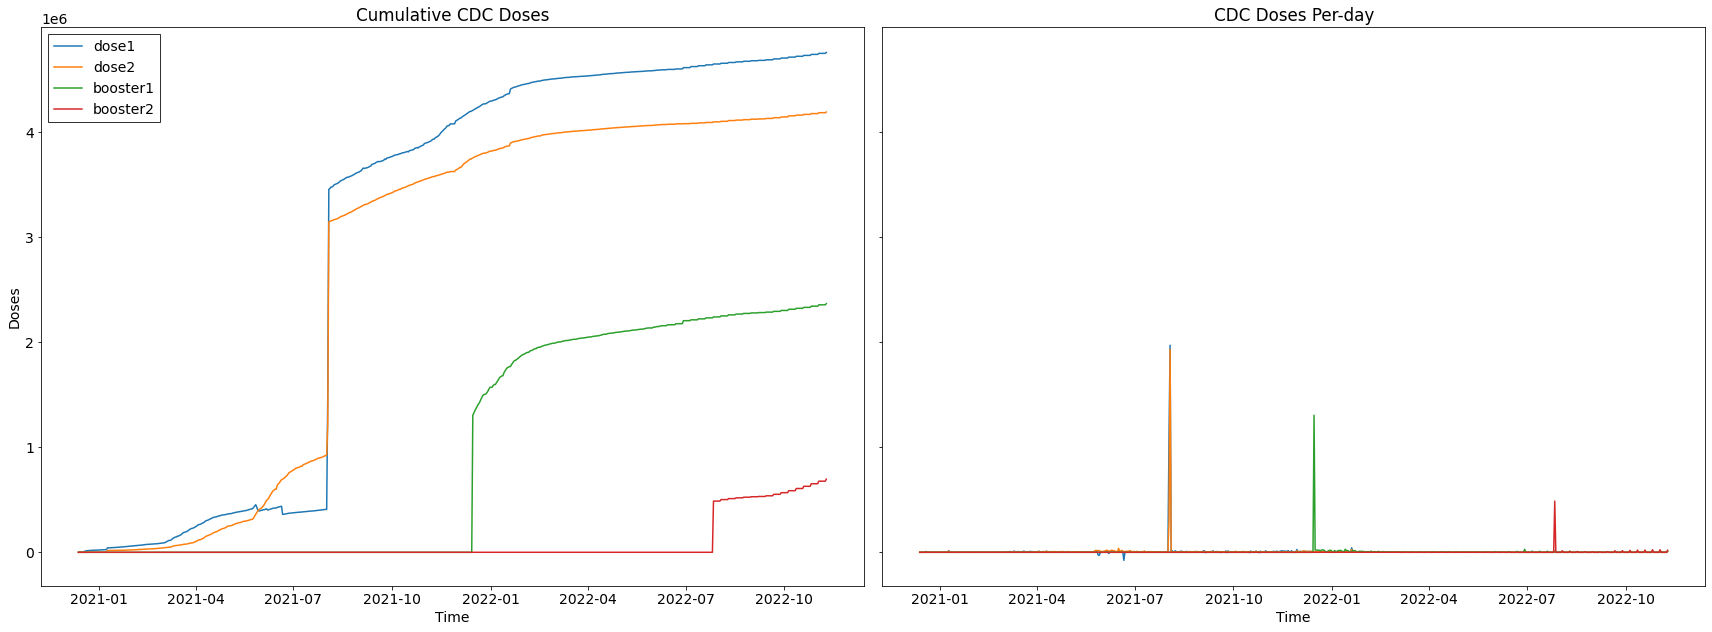

In [32]:
sum_cdc_data = cdc_data_redist.groupby("measure_date").sum()[["dose1","dose2","booster1","booster2"]]
sum_cdc_data = sum_cdc_data.reindex(pd.date_range(sum_cdc_data.index.min(),sum_cdc_data.index.max())).fillna(0)
sum_cdc_data.index.name = "measure_date"
sum_cdc_data_cumulative = sum_cdc_data.cumsum()
fig,ax = plt.subplots(figsize=(24,9),ncols=2,sharex=True,sharey=True)

for dose in ["dose1","dose2","booster1","booster2"]:
    ax[0].plot(sum_cdc_data_cumulative[dose],label=dose)
    ax[1].plot(sum_cdc_data[dose],label=dose)

ax[0].set_title("Cumulative CDC Doses")
ax[0].set_ylabel("Doses")
ax[0].set_xlabel("Time")
ax[0].legend(fancybox=False,edgecolor="black")

ax[1].set_title("CDC Doses Per-day")
ax[1].set_xlabel("Time")
plt.tight_layout()
plt.savefig("cumulative_cdc_doses.png")

## Step 2: Compare per Dose Measurements for CDC and CDPHE Data

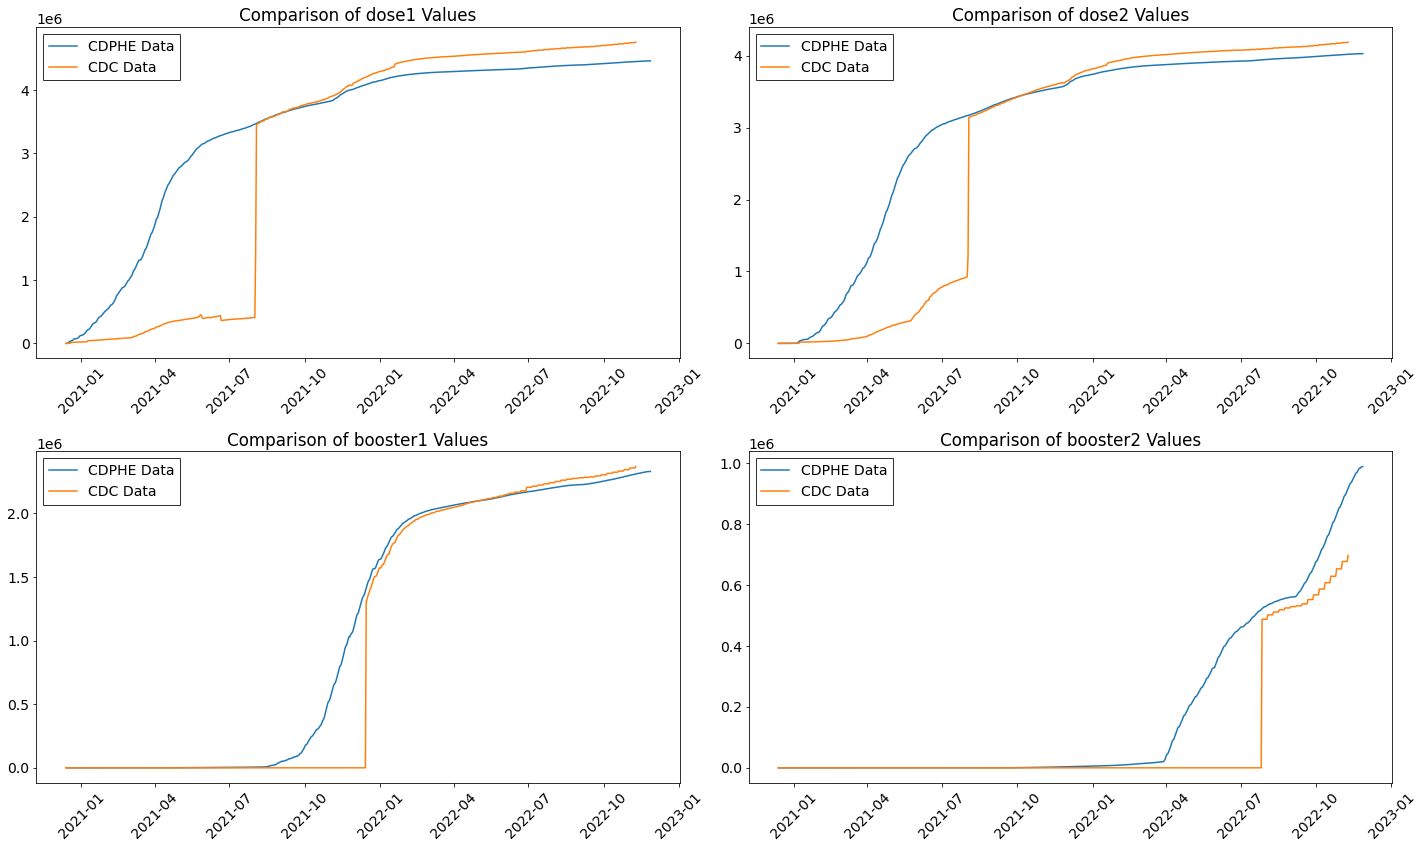

In [36]:
fig,axes = plt.subplots(figsize=(20,12),nrows=2,ncols=2)
axes = axes.ravel()
for ax,dose in zip(axes,["dose1","dose2","booster1","booster2"]):
    ax.set_title(f"Comparison of {dose} Values")
    ax.plot(sum_cdphe_data_cumulative.index.get_level_values("measure_date"),sum_cdphe_data_cumulative[dose],label="CDPHE Data")
    ax.plot(sum_cdc_data_cumulative.index.get_level_values("measure_date"),sum_cdc_data_cumulative[dose],label="CDC Data")
    ax.tick_params(axis="x",rotation=45)
    ax.legend(fancybox=False,edgecolor="black")
plt.tight_layout()
plt.savefig("dose_comparisons.png")

## Step 3: Data Smoothing
Try to find a smoothing function that makes the CDC data align nicely to the CDPHE data.

This will distribute the data across the earlier periods where reporting was sparse.

My first attempt uses a 90 day rolling average window to smooth the data.

In [37]:
sum_cdc_data_cumulative_backavg = sum_cdc_data_cumulative.iloc[::-1].rolling(90,min_periods=1).mean().iloc[::-1]

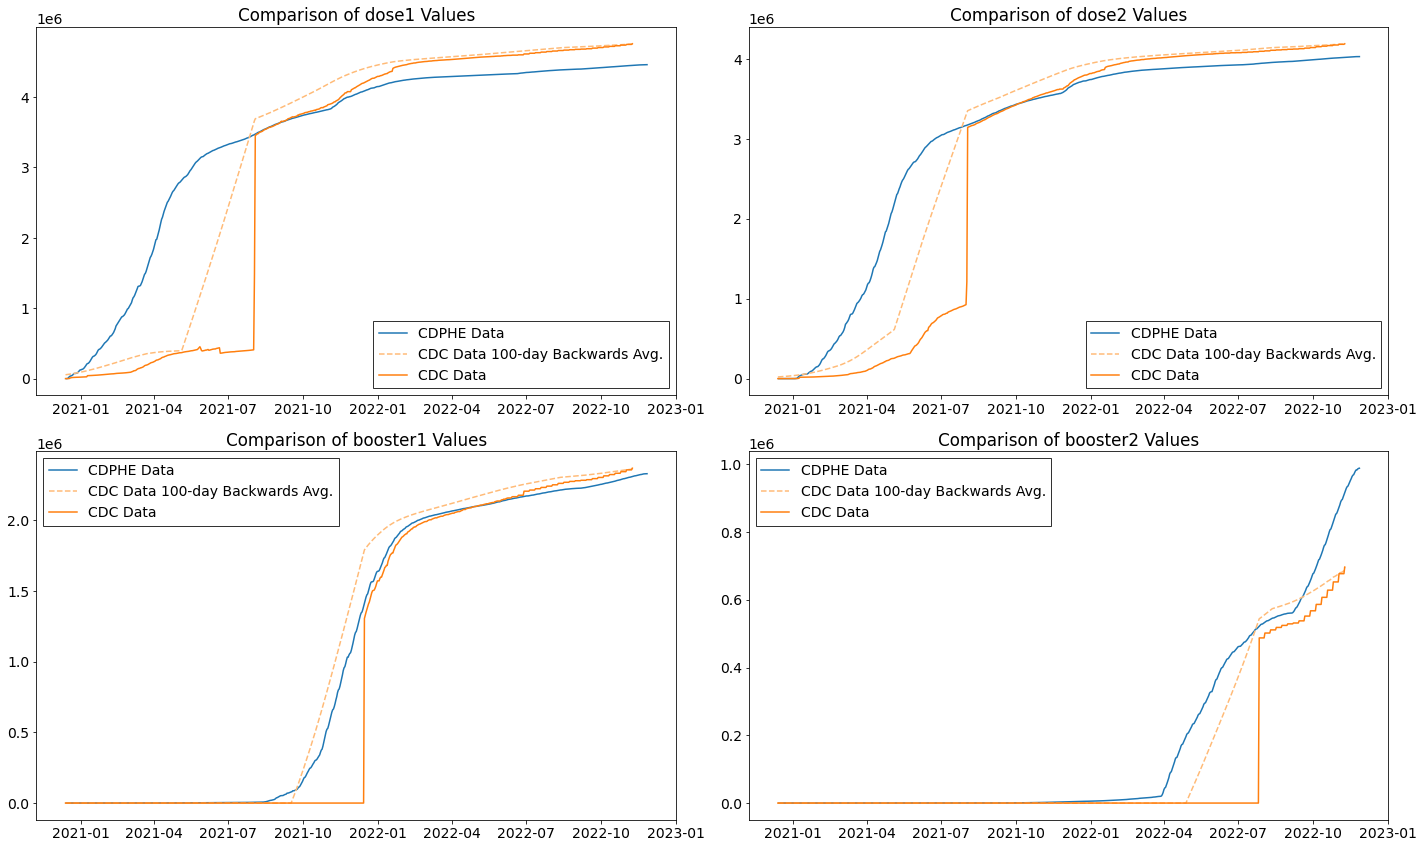

In [39]:
fig,axes = plt.subplots(figsize=(20,12),nrows=2,ncols=2)
axes = axes.ravel()
for ax,dose in zip(axes,["dose1","dose2","booster1","booster2"]):
    ax.set_title(f"Comparison of {dose} Values")
    ax.plot(sum_cdphe_data_cumulative.index.get_level_values("measure_date"),sum_cdphe_data_cumulative[dose],label="CDPHE Data",color=tab20(0))
    ax.plot(sum_cdc_data_cumulative_backavg.index.get_level_values("measure_date"),sum_cdc_data_cumulative_backavg[dose],label="CDC Data 100-day Backwards Avg.",color=tab20(3),linestyle="--")
    ax.plot(sum_cdc_data_cumulative.index.get_level_values("measure_date"),sum_cdc_data_cumulative[dose],label="CDC Data",color=tab20(2))
    ax.legend(fancybox=False,edgecolor="black")
plt.tight_layout()
plt.savefig("smoothing_90.png")

Our only parameter here is the rolling window size, which controls how far apart the values are spread. 

We can brute force search for the optimal window size for each dose separately:

In [40]:
def fit_rolling_window(x,window):
    return x.iloc[::-1].rolling(window,min_periods=1).mean().iloc[::-1]

Best window for 'dose1' is: 208
Best window for 'dose2' is: 169
Best window for 'booster1' is: 66
Best window for 'booster2' is: 139


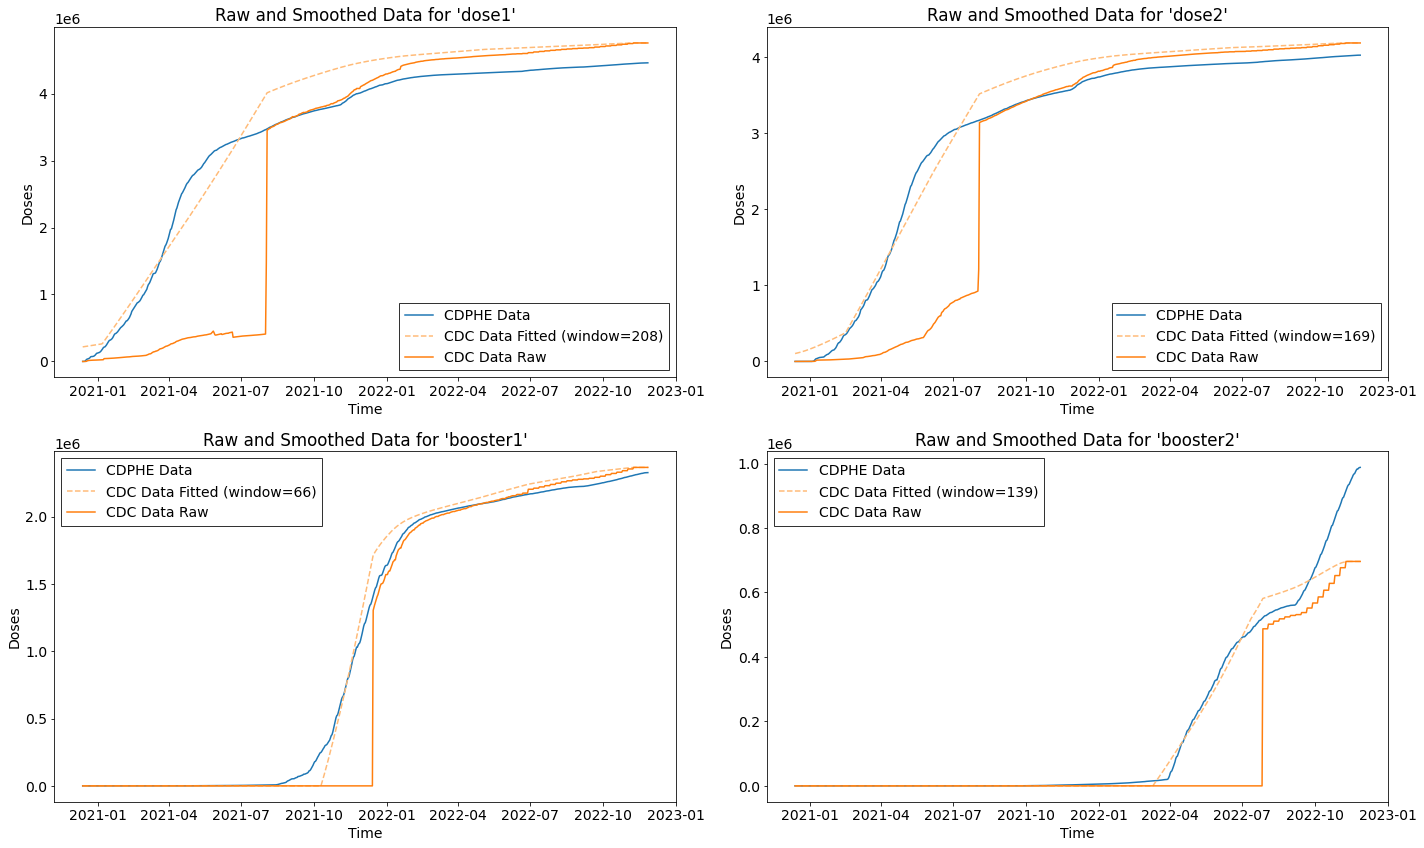

In [48]:
# Forward fill will carry forward the last cumulative value for whichever dataset ends earlier.
# We can fill in zeros for whichever dataset starts earlier,
x,y = sum_cdc_data_cumulative.align(sum_cdphe_data_cumulative,method="ffill")
x.fillna(0,inplace=True)
y.fillna(0,inplace=True)
dose_to_window = {}
fig,ax = plt.subplots(figsize=(20,12),nrows=2,ncols=2)
ax = ax.ravel()
for i,dose in enumerate(["dose1","dose2","booster1","booster2"]):
    use_x = x[dose]
    use_y = y[dose]
    best_rss = np.inf
    best_window = None
    best_fit_y = None
    for window in np.arange(15,300,dtype=int):
        fit_y = fit_rolling_window(use_x,window)
        rss = np.sum((fit_y - use_y)**2)
        if rss < best_rss:
            best_rss = rss
            best_window = window
            best_fit_y = fit_y
    dose_to_window[dose] = best_window
    sum_cdc_data_cumulative_backavg[dose] = best_fit_y
    ax[i].plot(use_y.index,use_y,label="CDPHE Data",color=tab20(0))
    ax[i].plot(best_fit_y.index,best_fit_y,label=f"CDC Data Fitted (window={int(best_window)})",color=tab20(3),linestyle="--")
    ax[i].plot(use_x.index,use_x,label="CDC Data Raw",color=tab20(2))
    ax[i].legend(fancybox=False,edgecolor="black")
    ax[i].set_title(f"Raw and Smoothed Data for '{dose}'")
    ax[i].set_xlabel("Time")
    ax[i].set_ylabel("Doses")
    print(f"Best window for '{dose}' is: {best_window}")
plt.tight_layout()
plt.savefig("smoothing_fitted.png")

In [49]:
def fit_exp_avg(x,alpha):
    return x.iloc[::-1].ewm(alpha=alpha,min_periods=1).mean().iloc[::-1]

In [56]:
!pip install statsmodels
from statsmodels.nonparametric.smoothers_lowess import lowess

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 43.5 MB/s eta 0:00:00m eta 0:00:010:01:01


In [65]:
use_x

measure_date
2020-12-13          0.0
2020-12-14          0.0
2020-12-15          0.0
2020-12-16          0.0
2020-12-17        261.0
                ...    
2022-11-23    4757752.0
2022-11-24    4757752.0
2022-11-25    4757752.0
2022-11-26    4757752.0
2022-11-27    4757752.0
Name: dose1, Length: 715, dtype: float64

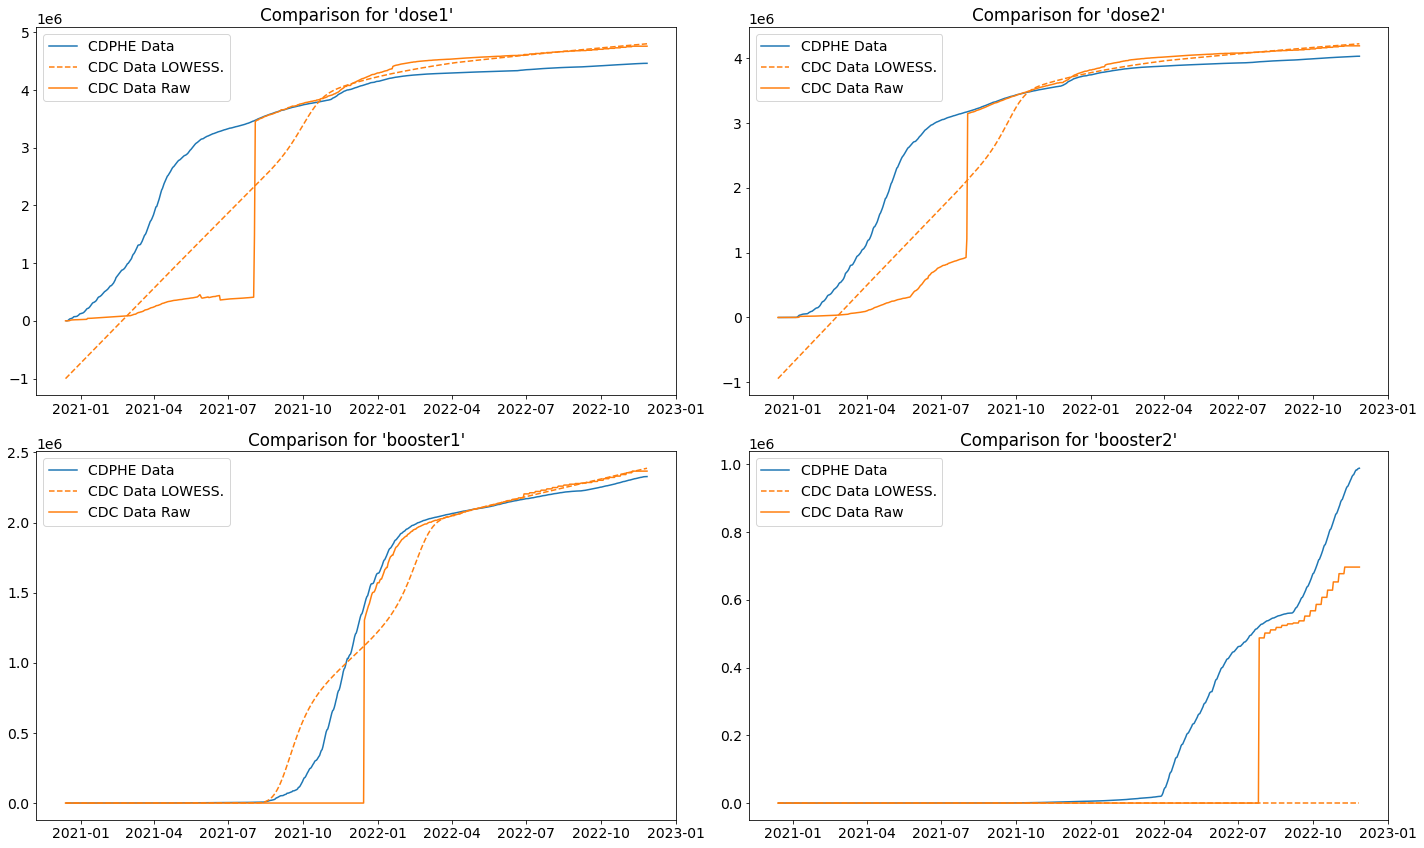

In [112]:
from scipy.optimize import curve_fit
sum_cdc_data_cumulative_lowess = sum_cdc_data_cumulative.copy()
x,y = sum_cdc_data_cumulative.align(sum_cdphe_data_cumulative,method="ffill")
x.fillna(0,inplace=True)
#y.fillna(0,inplace=True)
fig,ax = plt.subplots(figsize=(20,12),nrows=2,ncols=2)
ax = ax.ravel()
for i,dose in enumerate(["dose1","dose2","booster1","booster2"]):
    use_x = x[dose]
    use_y = y[dose]
    #best_alpha,_ = curve_fit(fit_exp_avg,use_x,use_y,bounds=[0,1])
    lowess_smoothed = pd.Series(lowess(use_x,use_x.index,return_sorted=False),index=use_y.index)
    #best_fit_y = fit_exp_avg(use_x,best_alpha)
    
    sum_cdc_data_cumulative_lowess[dose] = lowess_smoothed
    ax[i].plot(use_y.index,use_y,label="CDPHE Data",color=tab20(0))
    ax[i].plot(best_fit_y.index,lowess_smoothed,label="CDC Data LOWESS.",color=tab20(2),linestyle="--")
    ax[i].plot(use_x.index,use_x,label="CDC Data Raw",color=tab20(2))
    ax[i].legend()
    ax[i].set_title(f"Comparison for '{dose}'")
plt.tight_layout()
plt.savefig("smoothing_lowess.png")

I also try fitting a logistic function to the CDC data, which should provide a smoother "S-shaped" curve.

In [52]:
from scipy.optimize import curve_fit

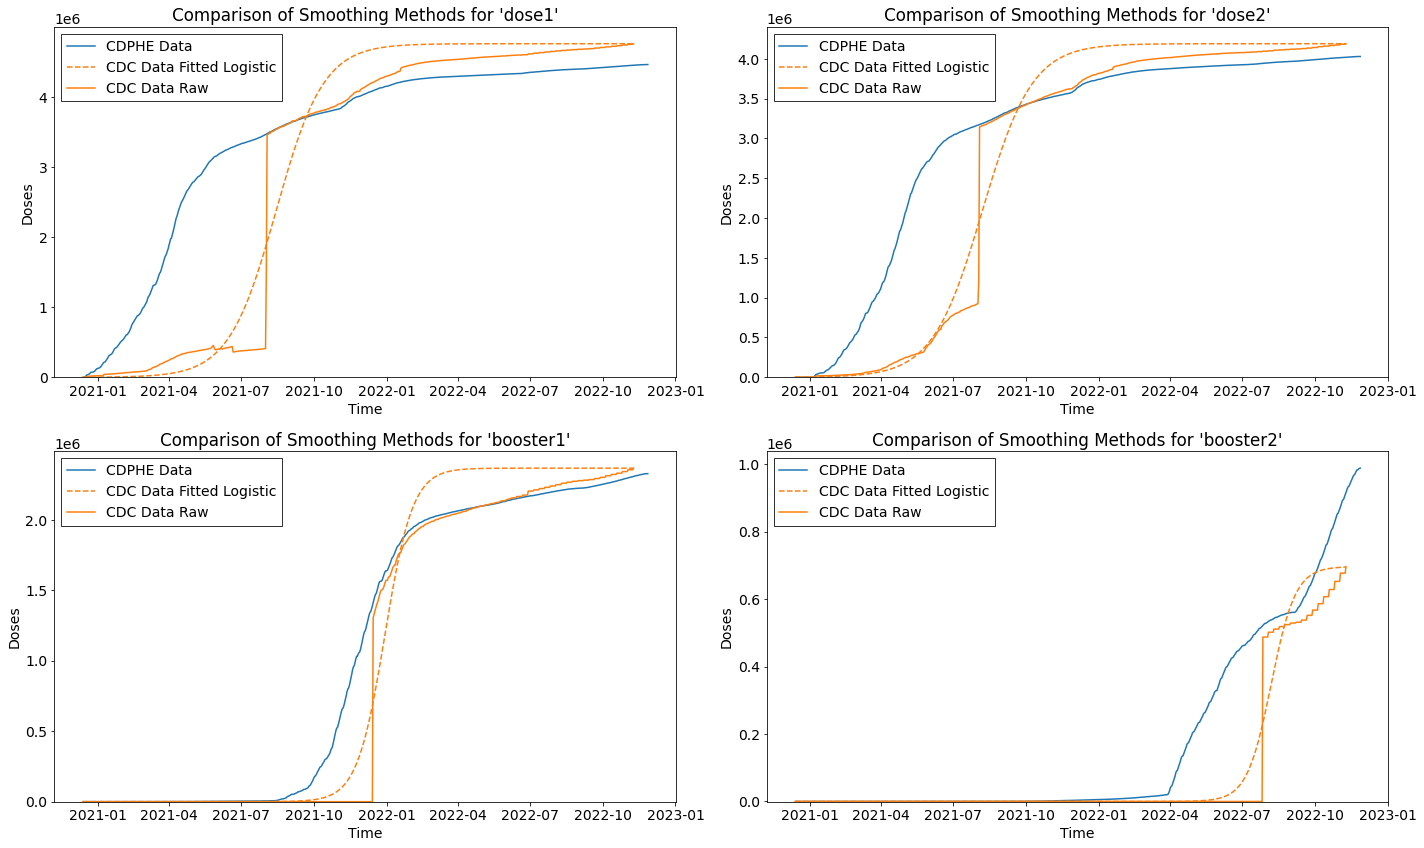

In [87]:
fig,ax = plt.subplots(figsize=(20,12),nrows=2,ncols=2)
ax = ax.ravel()
sum_cdc_data_cumulative_logst = sum_cdc_data_cumulative.copy()
for i,dose in enumerate(["dose1","dose2","booster1","booster2"]):
    
    tmp_cdc_data_cumulative_logst = sum_cdc_data_cumulative.reset_index(drop=True)
    
    tot_vax = tmp_cdc_data_cumulative_logst[dose].max()
    
    def logistic_curve(x,k,x0):
        return tot_vax/(1+np.exp(-k*(x-x0)))
    
    params,_ = curve_fit(logistic_curve,tmp_cdc_data_cumulative_logst.index.values,tmp_cdc_data_cumulative_logst[dose].values,bounds=([0,0],[np.inf,tmp_cdc_data_cumulative_logst.index.max()]))
    # Convert parameters back to dates
    fitted_curve = logistic_curve(tmp_cdc_data_cumulative_logst.index.values,*params)   
    sum_cdc_data_cumulative_logst[dose] = fitted_curve
    
    ax[i].plot(sum_cdphe_data_cumulative.index,sum_cdphe_data_cumulative[dose],label="CDPHE Data",color=tab20(0))
    ax[i].plot(sum_cdc_data_cumulative_logst.index,sum_cdc_data_cumulative_logst[dose],label="CDC Data Fitted Logistic",color=tab20(2),linestyle="--")
    #ax[i].plot(sum_cdc_data_cumulative_lowess.index,sum_cdc_data_cumulative_lowess[dose],label="CDC Data Fitted LOWESS",color=tab20(2),linestyle=":")
    ax[i].plot(sum_cdc_data_cumulative.index,sum_cdc_data_cumulative[dose],label="CDC Data Raw",color=tab20(2))
    ax[i].legend(fancybox=False,edgecolor="black")
    ax[i].set_ylim(-1000)
    ax[i].set_title(f"Comparison of Smoothing Methods for '{dose}'")
    ax[i].set_xlabel("Time")
    ax[i].set_ylabel("Doses")
plt.tight_layout()
plt.savefig("smoothing_logistic.png")

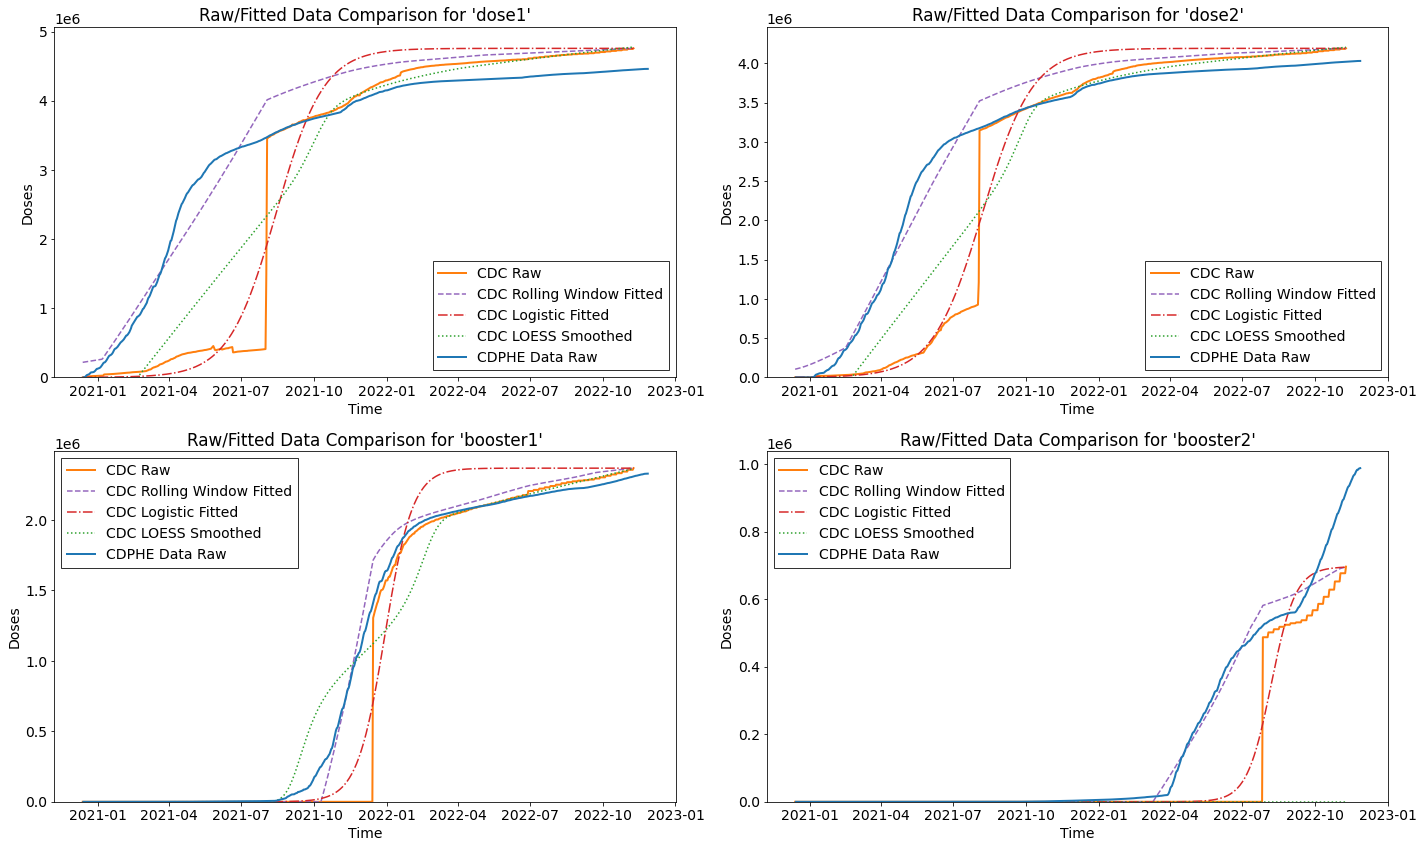

In [97]:
from matplotlib.cm import Dark2 as dark2
fig,ax = plt.subplots(figsize=(20,12),nrows=2,ncols=2)
ax = ax.ravel()
for i,dose in enumerate(["dose1","dose2","booster1","booster2"]):
    # Raw CDC Data
    ax[i].plot(sum_cdc_data_cumulative.index,sum_cdc_data_cumulative[dose],label="CDC Raw",color=tab10(1),linewidth=2)
    ax[i].plot(sum_cdc_data_cumulative_backavg.index,sum_cdc_data_cumulative_backavg[dose],label="CDC Rolling Window Fitted",color=tab10(4),linestyle="--")
    ax[i].plot(sum_cdc_data_cumulative_logst.index,sum_cdc_data_cumulative_logst[dose],label="CDC Logistic Fitted",color=tab10(3),linestyle="-.")
    ax[i].plot(sum_cdc_data_cumulative_lowess.index,sum_cdc_data_cumulative_lowess[dose],label="CDC LOESS Smoothed",color=tab10(2),linestyle=":")
    #ax[i].plot(sum_cdc_data_cumulative_ewm.index,sum_cdc_data_cumulative_ewm[dose],label="CDC Exp. Weighted Avg. Fitted",color=tab20c(7),linestyle=":")
    ax[i].plot(sum_cdphe_data_cumulative.index,sum_cdphe_data_cumulative[dose],label="CDPHE Data Raw",color=tab10(0),linewidth=2)
    ax[i].legend(fancybox=False,edgecolor="black")
    ax[i].set_ylim(0)
    ax[i].set_xlabel("Time")
    ax[i].set_ylabel("Doses")
    ax[i].set_title(f"Raw/Fitted Data Comparison for '{dose}'")
plt.tight_layout()
plt.savefig("smoothing_comparisons.png")

In [99]:
# Convert data back from cumulative by taking consecutive element differences, and filling in the first NA value with the original
# data value
sum_cdc_data_backavg = sum_cdc_data_cumulative_backavg.diff(1)[["dose1","dose2","booster1","booster2"]]
sum_cdc_data_logst = sum_cdc_data_cumulative_logst.diff(1)[["dose1","dose2","booster1","booster2"]]
sum_cdc_data_lowess = sum_cdc_data_cumulative_lowess.diff(1)[["dose1","dose2","booster1","booster2"]]

<AxesSubplot:title={'center':'Doses per-Day (Logistic Function Fitted)'}, xlabel='measure_date'>

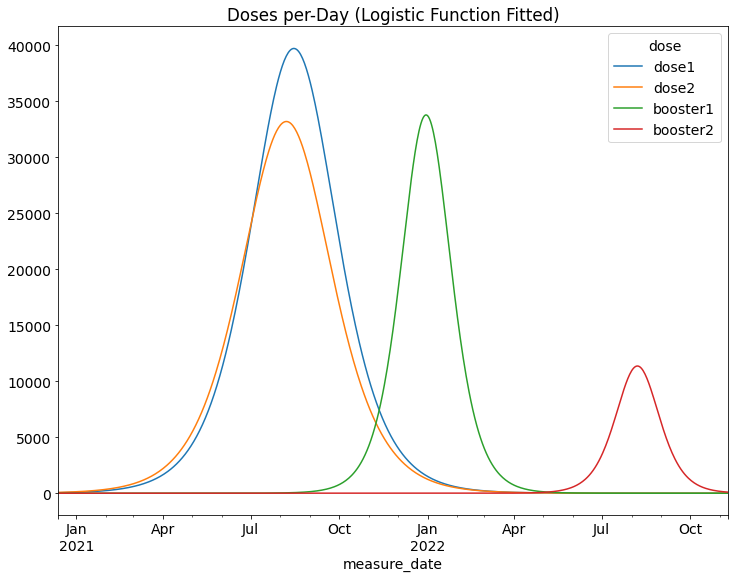

In [100]:
sum_cdc_data_logst.plot(figsize=(12,9),title="Doses per-Day (Logistic Function Fitted)")

<AxesSubplot:title={'center':'Doses per-Day (Rolling Avg. Fitted)'}, xlabel='measure_date'>

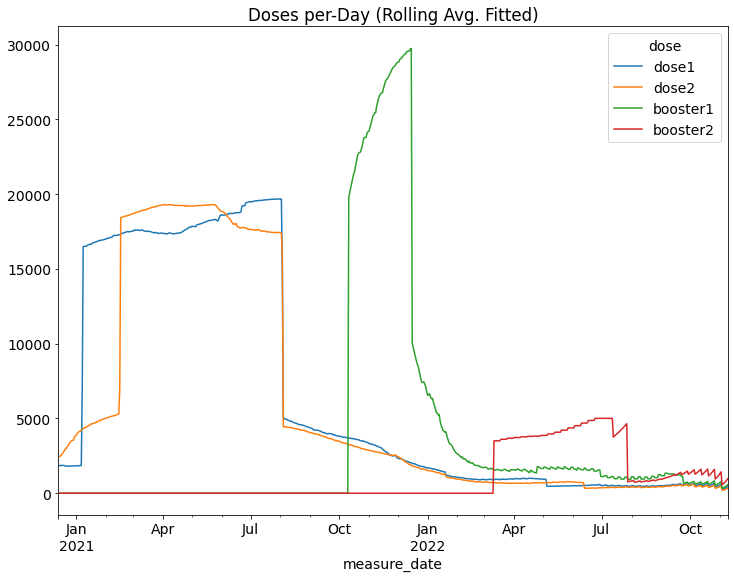

In [101]:
sum_cdc_data_backavg.plot(figsize=(12,9),title="Doses per-Day (Rolling Avg. Fitted)")

<AxesSubplot:title={'center':'Doses per-Day (Exponential Weighted Avg. Fitted)'}, xlabel='measure_date'>

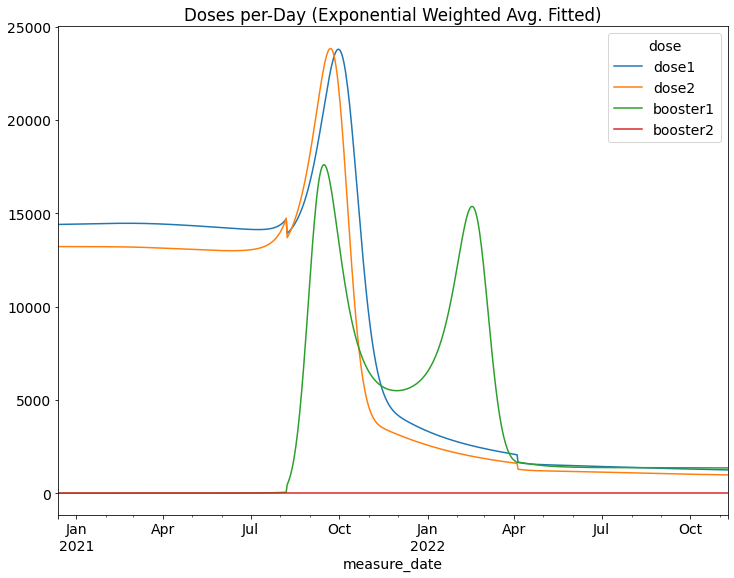

In [102]:
sum_cdc_data_lowess.plot(figsize=(12,9),title="Doses per-Day (Exponential Weighted Avg. Fitted)")

<AxesSubplot:xlabel='measure_date'>

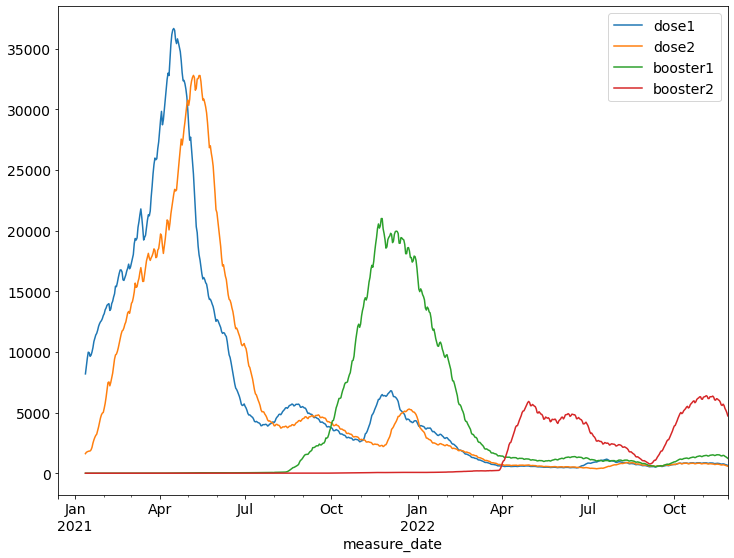

In [108]:
sum_cdphe_data[["dose1","dose2","booster1","booster2"]].rolling(30).mean().plot(figsize=(12,9))